## Product Recommendation Engine

# Table of contents

1. [Introduction](#introduction)
2. [Environment set-up](#setup)
3. [Exploratory analysis](#exploratory)
4. [Clustering](#clustering)
5. [Observing the clusters](#observing)
6. [Prediction on a new customer](#newCustomer)
    1. [Infer the cluster the new user blongs to](#infer)
      1. [Dimensionality reduction on the new customer](#manual_pca)
      2. [Calculate minimum distance from clusters](#centroid_distance)
    2. [Create the Utility Matrix only for that cluster](#utilityMatrix)
    3. [Singular Value Decomposition (SVD) on the Utility Matrix](#svd)
    4. [Correlation Matrix](#correlationMatrix)
    5. [Recommendation](#recommendation)


<a name="introduction"></a>

## 1. Introduction <a name="introduction"></a>

___Author___

Nicolò Cosimo Albanese (nicolo_albanese@outlook.it)

___Scenario___

An e-commerce site faces the challenge to recommend to the user products that may interest him.

The site has collected several data, including:

* Customer master data (genre, age, annual income, spending score).
* Customer preferences (products rated by each customer).

___Approach___

At first, clustering is implemented on the customers based on their master data.

When a new (or existing) user purchases a product (or simply open it web page) the recommendation is performed as follows:
* The closest cluster is determined on the customer's master data.
* The most popular products (highest rating) of that cluster are recommended ("___You may also like...___").
* The most highly rated products by customers who belong in the same cluster as the user and also rated the product the user has just bought/observed are returned ("___Suggested for you...___") through collaborative filtering.

___Data set___
* [Amazon product review dataset](https://www.kaggle.com/skillsmuggler/amazon-ratings): from this data set, the "ratings_Beauty.csv" file is used. It contains a list of user IDs, products IDs and relative ratings. It also contains a timestamp, but this information is not used in this contest. This data set contains more than 2 millions of product reviews on the product section 'Beauty' collected in the period May 1996 - July 2014.

* A synthetic data set created ad-hoc to implement fake users data: in this data set, we associate user IDs from the Amazon data set to __fictional__ master data. Age, genre, annual income are completely __invented__ for the analysis' purpose. This data set is inspired by the customer data set available in [this](https://github.com/lucko515/clustering-python/blob/master/Customer%20in%20Mall%20clusterng/Mall_Customers.csv) repository, that also inspired the PCA+K-Means clustering representation approach (Section 4).

## 2. Environment set-up <a name="setup"></a>




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import math

## 3. Exploratory analysis <a name="exploratory"></a>

In [ ]:
customers = pd.read_csv('/content/drive/My Drive/data/customers_info.csv')
customers.head(10)

,CustomerID,Genre,Age,Annual Income,Spending Score
0,A39HTATAQ9V7YF,Male,19,15,39
1,A3JM6GV9MNOF9X,Male,21,15,81
2,A1Z513UWSAAO0F,Female,20,16,6
3,A1WMRR494NWEWV,Female,23,16,77
4,A3IAAVS479H7M7,Female,31,17,40
5,AKJHHD5VEH7VG,Female,22,17,76
6,A3V3RE4132GKRO,Female,35,18,6
7,A327B0I7CYTEJC,Female,23,18,94
8,AIFAAVTUYHEHB,Male,64,19,3
9,AKGB62WGF35J8,Female,30,19,72


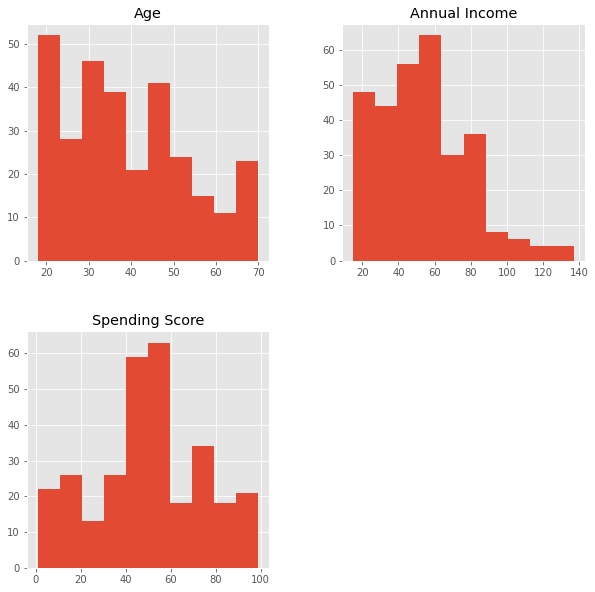

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
customers.hist();

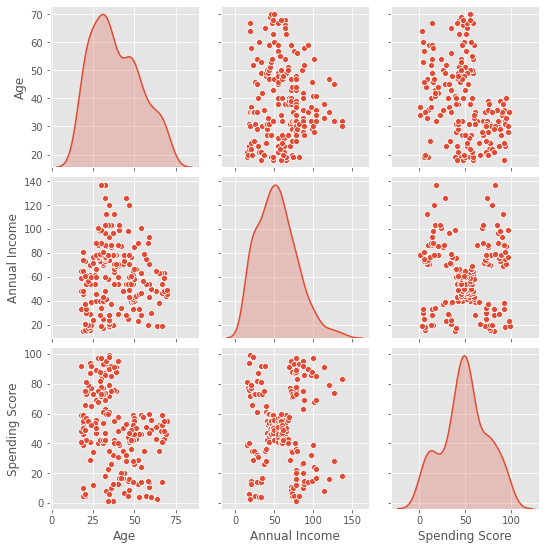

In [ ]:
import seaborn as sb
sb.pairplot(customers, diag_kind="kde")

In [ ]:
correlation_data = customers.corr()
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)

,Age,Annual Income,Spending Score
Age,1.000000,0.026524,-0.357481
Annual Income,0.026524,1.000000,0.008637
Spending Score,-0.357481,0.008637,1.000000


## 4. Clustering <a name="clustering"></a>

In [ ]:
# remove customer id
customers_data = customers.drop('CustomerID', axis=1)

# encode the gender to 0-1 instead of Male-Female
encode = LabelEncoder()
encoded_sex = encode.fit_transform(customers_data.iloc[:, 0])
customers_data['Genre'] = encoded_sex

# dimensionality reduction through PCA
pca_reducer = PCA(n_components=2)
reduced_data = pca_reducer.fit_transform(customers_data)

# clustering the customers (let's suppose we have 5 clusters)
km = KMeans(n_clusters=5)
cluster_reduced = km.fit(reduced_data)

Text(0.5, 1.0, 'Customers clusters')

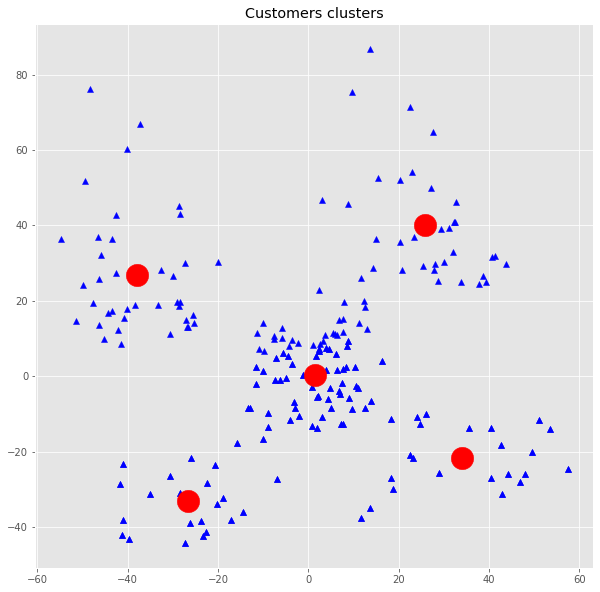

In [ ]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='^', color='blue', label='Datapoints')
plt.scatter(cluster_reduced.cluster_centers_[:, 0], cluster_reduced.cluster_centers_[:, 1], s=500, marker='o', color='red', label='Clusters')
plt.title("Customers clusters")

## 5. Observing the clusters <a name="observing"></a>

In [ ]:
predict = km.predict(reduced_data)
customers['Cluster'] = pd.Series(predict)

customers.head()

,CustomerID,Genre,Age,Annual Income,Spending Score,Cluster
0,A39HTATAQ9V7YF,Male,19,15,39,3
1,A3JM6GV9MNOF9X,Male,21,15,81,1
2,A1Z513UWSAAO0F,Female,20,16,6,3
3,A1WMRR494NWEWV,Female,23,16,77,1
4,A3IAAVS479H7M7,Female,31,17,40,3


         Annual Income  Spending Score        Age
Cluster                                          
0            88.735294       16.764706  41.647059
1            25.727273       79.363636  25.272727
2            86.538462       82.128205  32.692308
3            26.304348       20.913043  45.217391
4            53.532847       49.678832  42.788321


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Average features in each cluster')

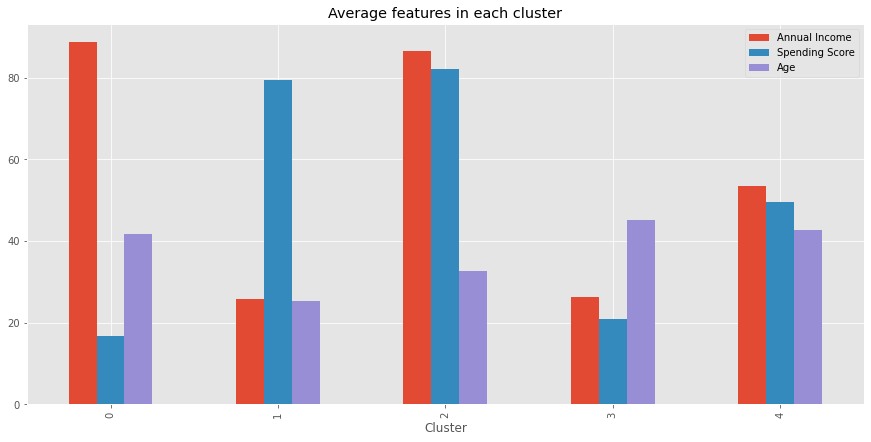

In [ ]:
print(customers.groupby("Cluster")["Annual Income", "Spending Score", "Age"].mean())

fig, ax = plt.subplots(figsize=(15,7))
customers.groupby("Cluster")["Annual Income", "Spending Score", "Age"].mean().plot.bar(ax=ax)
plt.title("Average features in each cluster")

                Annual Income  Spending Score        Age
Cluster Genre                                           
0       Female      92.333333       21.600000  44.600000
        Male        85.894737       12.947368  39.315789
1       Female      25.692308       80.538462  25.461538
        Male        25.777778       77.666667  25.000000
2       Female      86.047619       81.666667  32.190476
        Male        87.111111       82.666667  33.277778
3       Female      27.357143       21.714286  43.214286
        Male        24.666667       19.666667  48.333333
4       Female      53.456790       49.185185  41.382716
        Male        53.642857       50.392857  44.821429


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Average values in each cluster grouped by genre')

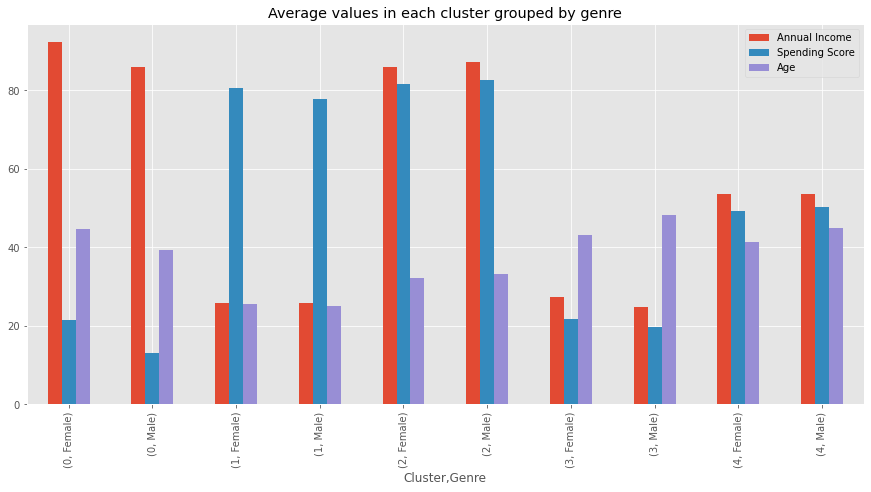

In [ ]:
print(customers.groupby(["Cluster", "Genre"])["Annual Income", "Spending Score", "Age"].mean())

fig, ax = plt.subplots(figsize=(15,7))
customers.groupby(["Cluster", "Genre"])["Annual Income", "Spending Score", "Age"].mean().plot.bar(ax=ax)
plt.title("Average values in each cluster grouped by genre")

In [ ]:
# save clusters information for future analysis
clusters_df = pd.DataFrame(customers.groupby("Cluster")["Annual Income", "Spending Score", "Age"].mean(), columns = [ 'Annual Income', 'Spending Score', 'Age'])

clusters_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Annual Income,Spending Score,Age
Cluster,,,
0,88.735294,16.764706,41.647059
1,25.727273,79.363636,25.272727
2,86.538462,82.128205,32.692308
3,26.304348,20.913043,45.217391
4,53.532847,49.678832,42.788321


## 6. Prediction on a new customer <a name="newCustomer"></a>

### 6.1 Infer the cluster the new user belongs to <a name="infer"></a>



In [ ]:
new_customer = {
    "CustomerID": "C37JEAEAF1R8RA",
     "Genre": "Male",
     "Age": 26,
     "Annual Income": 78,
     "Spending Score": 91
}

new_customer_df = pd.DataFrame(new_customer, index=[0])

new_customer_df

,CustomerID,Genre,Age,Annual Income,Spending Score
0,C37JEAEAF1R8RA,Male,26,78,91


We preprocess the new customer's information as we have done previously with all customers: the ID is removed and the genre is labeled.

In [ ]:
# preprocess the new customer's information
new_customer_df = new_customer_df.drop('CustomerID', axis=1)

# encode the gender to 0-1 instead of Male-Female
encoded_sex = encode.fit_transform(new_customer_df.iloc[:, 0])
new_customer_df['Genre'] = encoded_sex

#### 6.1.1 Dimensionality reduction on the new customer <a name="manual_pca"></a>

Now we have to perform dimensionality reduction on the new customer to represent it in the same space as the clusters, and then calculate the minimum distance between all clusters' centroids to infer the cluster the new customer belongs to.

We have to perform this calculation manually through the __projection matrix__.
Therefore, we also estimate the error in the manual calculation by checking if we would get the same output as "fit_transform" on the original data.

In [ ]:
fit_pca = pca_reducer.fit(customers_data)

# projection matrix
projection_matrix = fit_pca.components_

# check if it is orthogonal 
print("Projection matrix:\n", np.dot(projection_matrix, np.transpose(projection_matrix)))

# mean vector all data
mean_vc = customers_data.mean(axis = 0)

# center with old mean and rotate
np.dot(new_customer_df - mean_vc, np.transpose(projection_matrix))

# check if we get the same output as fit_transform (on the original data)
out1 = pca_reducer.fit_transform(customers_data)
out2 = np.dot(customers_data - mean_vc, np.transpose(projection_matrix))
diff = abs(out1 - out2)

print("\nManual reduction error between ", diff.min() , " and ", diff.max())

Projection matrix:
 [[1.00000000e+00 3.76792002e-16]
 [3.76792002e-16 1.00000000e+00]]

Manual reduction error between  0.0  and  5.684341886080802e-14


The error is very close to zero. As we have verified that our procedure is correct, we perform dimensionality reduction on the new customer.

In [ ]:
new_customer_reduced = np.dot(new_customer_df - mean_vc, np.transpose(projection_matrix))

#### 6.1.2 Calculate minimum distance from clusters' centroids <a name="centroid_distance"></a>

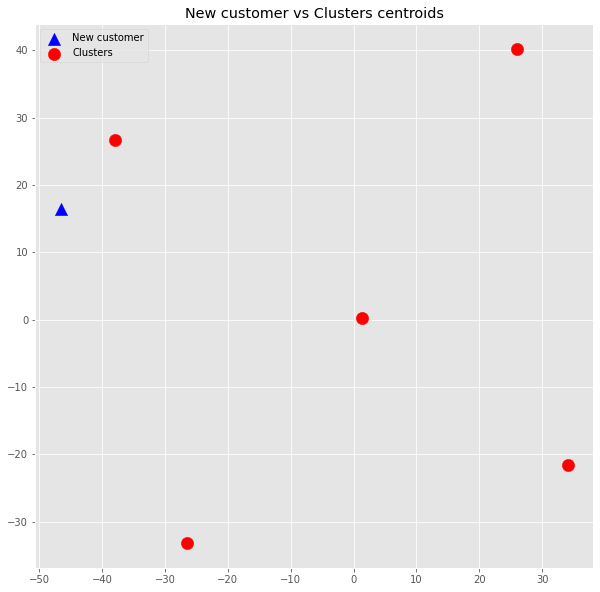

In [ ]:
plt.scatter(new_customer_reduced[:, 0], new_customer_reduced[:, 1], marker='^', s=150, color='blue', label='New customer')
plt.scatter(cluster_reduced.cluster_centers_[:, 0], cluster_reduced.cluster_centers_[:, 1], s=150, marker='o', color='red', label='Clusters')
plt.title("New customer vs Clusters centroids")
plt.legend()

In [ ]:
def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist

In [ ]:
new_customer_distances = []

for i in range(len(cluster_reduced.cluster_centers_)):
  new_customer_distances.append( calculateDistance(new_customer_reduced[0][0], new_customer_reduced[0][1], cluster_reduced.cluster_centers_[i][1], cluster_reduced.cluster_centers_[i][1] ) )

print("The cluster for this customer is: ", new_customer_clusters.index(min(new_customer_clusters)))

print("\nThe distances from each cluster's centroid is:")
for i in range(len(new_customer_distances)):
  print(f'[cluster {i}]\tDistance from centroid: {new_customer_distances[i]}')

The cluster for this customer is:  0

The distances from each cluster's centroid is:
[cluster 0]	Distance from centroid: 45.508290945835604
[cluster 1]	Distance from centroid: 49.58672068235507
[cluster 2]	Distance from centroid: 90.0087224750613
[cluster 3]	Distance from centroid: 51.37585279697813
[cluster 4]	Distance from centroid: 74.0731900601039


### 6.2 Create the Utility Matrix only for that cluster <a name="utilityMatrix"></a>

In [ ]:
clustered_customers_df = customers.loc[customers["Cluster"] == new_customer_clusters.index(min(new_customer_clusters))]

In [ ]:
# import the ratings
ratings_df = pd.read_csv('/content/drive/My Drive/data/ratings_Beauty.csv')

# remove timestamp column
ratings_df = ratings_df.drop('Timestamp', axis=1)

# remove NULLs
ratings_df = ratings_df.dropna()

ratings_df.head()

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0
2,A1Z513UWSAAO0F,0558925278,5.0
3,A1WMRR494NWEWV,0733001998,4.0
4,A3IAAVS479H7M7,0737104473,1.0


In [ ]:
# filter the ratings for the customers of that cluster
ratings_cluster = ratings_df[ratings_df['UserId'].isin(clustered_customers_df["CustomerID"])]

In [ ]:
# let's check that the original ratings dataframe is reduced

print("Original ratings dimension: ", ratings_df.shape)
print("Ratings filtered by cluster dimension: ", ratings_cluster.shape)

Original ratings dimension:  (2023070, 3)
Ratings filtered by cluster dimension:  (89, 3)


In [ ]:
# finally, the Utility Matrix:
ratings_utility_matrix = ratings_cluster.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,4057553908,5297000963,5357954771,535795531X,535795545X,5357955743,5357955786,5357955832,5357955867,5357955905,5357955948,5357956014,5357956111,5357956227,6022600685,602260074X,B0001EKTZQ,B0007CXXYG,B000980PGM,B0009EXOO6,B0009I4MFW,B000ASDGK8,B000H73UOO,B000HRVC5I,B000ICR9UO,B000MS3XW2,B000MS5M9O,B000O2OB9K,B000PKUZC8,B000PKZFFU,B000PKZG22,B000U0F9GA,B000ULL7C4,B000VIY38G,B000XSPQ62,B000ZLNRAE,B0012FOOF4,B0012NXGRI,B0012O2KWY,B0013EF31I,B0013NE2Y8,B0014R2YRA,B0015Q0RP6,B0016LACRS,B0018CQKXK,B001B1MUSW,B001F51PXA,B001HKR6WM,B001TOSNSC,B0028J7DXS,B002KHS6IO,B002QANC2A,B002R23I76,B002TPO0W8,B002XY7HDE,B003GCWJFS,B003UTEE32,B004AGMBHK,B004BPVF7W,B004CDTD90,B004JTSUJ6,B004M0U3YM,B004TSFBNK,B004TSFEBY,B004WMJDS2,B0050KLBXU,B005JDPI28,B005JDPJAY,B0082D69H0,B00AYLYETS,B00FU574H2
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A10ZKDOZOSH219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A13IIHXY0QX4Y4,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,5,0,4,0,0,0,5,0,0,0,0,0,4,5,5,0,0,5,5,5,3,0,0,5,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
A16495HOSCEV0N,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A18CAHNYYC8AA3,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A18X2IP46I5JB8,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Transposed
X = ratings_utility_matrix.T
X.head()

UserId,A10ZKDOZOSH219,A13IIHXY0QX4Y4,A16495HOSCEV0N,A18CAHNYYC8AA3,A18X2IP46I5JB8,A1B07LXV78TWZ,A1C4OJZCDI8LN3,A1L8MP88Q3DXXJ,A1MOOCFYF4BW9F,A1NNJ0MNFIF3Z8,A1UDWB8WFFGN55,A1X1X91COEBHVI,A1XD9BN1CBR8U4,A24662VRPFY4YK,A29AQSCFQ1OZ9R,A2DOQ89OLXNHNL,A2EH8T3LQS6EET,A2UQZD76FKVQ6D,A34LP4FWKYTHB5,A3590W7FEAGQY4,A364UC5PLUM8M3,A38JQUXZTKKHQP,A39GFZUNMWJ44J,A3B0M39TDARC6X,A3UFMKLD77O21S,A3VUS3HC1CCVOQ,A7SVI5Q1WC3UP,ADZZCC6UUMA0N,AM0RSD59GI2IK,AOJRTF5PJMIR6,AQFATFCB1HBG3,ARUSOE3CJ7TNF,AVCSVH9L0BPIF,AYHZNXRPOHMO2
ProductId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4057553908,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5297000963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5357954771,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0
535795531X,0,3,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,5,5,0,0,0,0,0,0,0,0,0
535795545X,0,0,0,0,5,0,0,0,0,0,0,0,0,0,5,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 6.3 Singular Value Decomposition (SVD) on the Utility Matrix <a name="svd"></a>

In [ ]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(71, 10)

### 6.4 Correlation Matrix <a name="correlationMatrix"></a>

In [ ]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(71, 71)

### 6.5 Recommendation <a name="recommendation"></a>

Now the prediction: let's pretend that the new user has purchased (or has just searched for) the product ID "B00AYLYETS".

We can make two predictions:

* Suggest to the user the products that were rated the most by users in his cluster that also bought this product ("__Products suggested for you...__")

* Suggest to the user the most popular products in his cluster ("__You may also like...__")

In [ ]:
product_bought_by_user = "B00AYLYETS"

product_names = list(X.index)
product_ID = product_names.index(product_bought_by_user)

correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

Recommend = list(X.index[correlation_product_ID > 0.90])

# We do not want to suggest also the product that was just purchased/observed
Recommend.remove(product_bought_by_user) 

In [ ]:
print("Suggested for you... [recommendation based on customers' clustering followed by collaborative filtering]")

j = 0
for i in Recommend[0:10]:
  print(f'[{j+1}]\t{i}')
  j+=1

Suggested for you... [recommendation based on customers' clustering followed by collaborative filtering]
[1]	B000HRVC5I
[2]	B000MS3XW2
[3]	B000MS5M9O
[4]	B000U0F9GA
[5]	B0018CQKXK
[6]	B002QANC2A
[7]	B002XY7HDE
[8]	B003GCWJFS
[9]	B003UTEE32
[10]	B004WMJDS2


In [ ]:
popular_products_in_the_cluster = pd.DataFrame(ratings_cluster.groupby('ProductId')['Rating'].count())
most_popular = popular_products_in_the_cluster.sort_values('Rating', ascending=False)

print("You may also like... [recommendation based on customers' clustering followed by popularity of products inside the cluster]")

j = 0
for i in most_popular.head(10).index.values:
  print(f'[{j+1}]\t{i}')
  j+=1


You may also like... [recommendation based on customers' clustering followed by popularity of products inside the cluster]
[1]	5357955948
[2]	535795531X
[3]	535795545X
[4]	5357956111
[5]	6022600685
[6]	5357955786
[7]	5357955867
[8]	5357955905
[9]	4057553908
[10]	B001TOSNSC


We notice immediately that the most popular products, even if calculated strictly inside the user's cluster (therefore heavily pre-filtered), are not necessarily the ones that the engine would recommend when searching for similarities between the user's purchase and the choices of other (similar) users who also purchased the same product.

In this contest, we suggested both:

1) "___Suggested for you...___": most rated products by other users with similar purchase history inside the user's cluster.

2) "___You may also like...___": most popular products inside the user's cluster.
